# Printer Development Documentation

In [1]:
import numpy as np
import matplotlib.pyplot as plt

## Pitch Diameter

To find the path of a belt around pulleys, we need to calculate the pitch diameter (PD) of the belt for an accurate CAD representation.

The equation for pitch diameter is as follows: $$ PD = \frac{pitch \ \cdot \ numTeeth}{\pi} $$

where pitch is the distance between the teeth of the belt, and numTeeth is the amount of teeth on the pulley.




<img src="images/belt_dimensions.jpg" alt="Belt Dimensions" width="400">

For this use case, I am using 2GT-GT3 Belts. The dimensions of the belt can be found in the table above.

In addition, a 20 tooth pulley is used. Using the formula above, the PD can be calculated.


In [2]:
num_teeth = 20
pitch = 2       # mm

PD = pitch * num_teeth / np.pi
print(PD)

12.732395447351628


Since the table does not present values for the distances to the teeth and outer edge based on the PD, they are calculated below:

In [3]:
PLD = 0.254
i = 0.63
h = 0.75

belt_teeth_distance = PLD + h
outer_distance = i - PLD

print(belt_teeth_distance)
print(outer_distance)

1.004
0.376


This can be used to find the total diameter of the belt. 

In [4]:
outer_diam = PD + 2 * outer_distance
print(outer_diam)

13.484395447351629


This value is important because slots to fit a belt must meet this minimum diameter to not interfere with the belt. For this example, a good slot diameter would be 15mm to allow some clearance



## Cantilever Beam Deflection

To ensure that the vertical square tubes are suitable for the vertical beams of the printer, a basic assessment of bending displacement is undertaken.

The moment of inertia serves as a measure of an object's resistance to changes in rotational motion. For a square, the moment of inertia about its centroidal axis is given by:

$$I_{square} = \frac{b^4}{12}$$

where $b$ represents the length of a side.

In the case of a hollow square tube, the total moment of inertia is calculated by subtracting the moment of inertia of the inner wall from that of the outer wall:

$$b^4 = b_{\text{outer}}^4 - b_{\text{inner}}^4$$

$$I_{\text{square tube}} = \frac{b_{\text{outer}}^4 - b_{\text{inner}}^4}{12}$$

By applying a point load to the end of the cantilever beam in a simulation, the resulting displacement can be calculated using the formula:

$$\delta = \frac{F L^3}{3 E I}$$

where $F$ represents the applied force, $L$ denotes the length of the beam, and $E$ is Young's Modulus.


In [5]:
# Specs of the tube used:
b_outer = 1.5 * 0.0254              # in -> m
thickness = 0.12 * 0.0254           # in -> m
E_square_tube = 200e9               # Pa

L = 0.400                           # m
F = 1000                            # N

b_inner = b_outer - 2 * thickness
I_square_tube = (b_outer**4 - b_inner**4) / 12

delta_square_tube = (F * L**3) / (3.0 * E_square_tube * I_square_tube)

print("{:.3e}".format(I_square_tube), 'm^4')        # m^4
print(round(delta_square_tube * 1000, 3), 'mm')     # mm

8.817e-08 m^4
1.21 mm


In [6]:
# Comparison to 4040 Aluminum Extrusion of the same length
E_extrusion = 68.9e9                # Pa
I_extrusion = 13.787e-8             # m^4

delta_extrusion = (F * L**3) / (3.0 * E_extrusion * I_extrusion)

print("{:.3e}".format(I_extrusion), 'm^4')          # m^4
print(round(delta_extrusion * 1000, 3), 'mm')       # mm

1.379e-07 m^4
2.246 mm


Results show that the steel square tube outperforms the aluminum extrusion in deflection resistance.

Additionally, these findings illustrate a non-ideal representation of cantilever beam behavior. In an ideal scenario, we would consider a simply supported beam, anchored at both ends. This aspect will be further investigated to assess the potential impact of temperature gradients between the top and bottom of the chamber on beam perpendicularity, potentially leading to binding issues in the linear rails.

For the case of a simply supported beam, the displacement is given by:

$$ \delta_{ss} = \frac{F L^3}{48 E I}$$

In [7]:
delta_ss = (F * L**3) / (48.0 * E_square_tube * I_square_tube)
print(round(delta_ss * 1000, 3), 'mm')       # mm

0.076 mm


As exercise, a plot of varying lengths was made to demonstrate the nonlinearity of total length's effect on displacement.

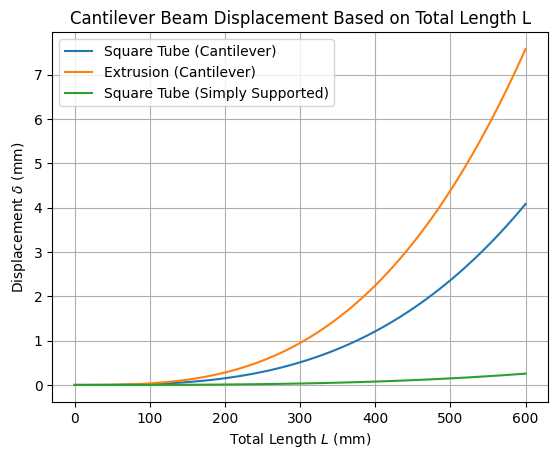

In [8]:
# Varying the length
L_varying = np.linspace(0, 0.6, num=100)      # m
L_varying_mm = L_varying * 1000                     # mm

delta_square_tube = (F * L_varying**3) / (3.0 * E_square_tube * I_square_tube) * 1000       # mm
delta_extrusion = (F * L_varying**3) / (3.0 * E_extrusion * I_extrusion) * 1000             # mm
delta_ss = (F * L_varying**3) / (48.0 * E_square_tube * I_square_tube) * 1000               # mm



plt.plot(L_varying_mm, delta_square_tube, label='Square Tube (Cantilever)')
plt.plot(L_varying_mm, delta_extrusion, label='Extrusion (Cantilever)')
plt.plot(L_varying_mm, delta_ss, label='Square Tube (Simply Supported)')
plt.xlabel('Total Length $L$ (mm)')
plt.ylabel('Displacement $\\delta$ (mm)')
plt.title('Cantilever Beam Displacement Based on Total Length L')
plt.grid(True)
plt.legend()
plt.show()

## Thermal Expansion 

A temperature difference between the top and bottom plate can cause the top plate to expand more than the bottom plate, potentially leading to misalignment and printing inaccuracies. To determine if this thermal expansion is negligible, we use the thermal expansion equation:

$$\Delta L = \alpha L_0 \Delta T$$


The thermal expansion of a 1-D beam changes with respect to the thermal expansion coefficient $\alpha$ , the inital length $L_0$, and the change in temperature $\Delta T$. By calculating $\Delta L$ of the top and bottom plate, we can assess whether the expansion is within acceptable limits for maintaining the printer's precision.

In [9]:
L_o = 0.5        # m
alpha = 11.5e-6  # m/m-°C
T_i = 25         # C
T_f_top = 100    # C
T_f_bot = 80     # C

L_delta_top = L_o * alpha * (T_f_top - T_i) # m
L_delta_bot = L_o * alpha * (T_f_bot - T_i) # m
L_diff = L_delta_top - L_delta_bot

print(round(L_diff*1000, 3), "mm")

0.115 mm


The length difference found is not as insignificant as predicted. However, it is still small and can be neglected if efforts are focused on reducing the temperature gradient between the plates. This concern will not be addressed unless issues arise later.